# Issue with forward integration with LMC

Following the `galpy` documentation example, [Including the Milky Way center’s barycentric acceleration due to the Large Magellanic Cloud in orbit integrations](https://docs.galpy.org/en/v1.8.1/orbit.html#new-in-v1-8-example-including-the-milky-way-center-s-barycentric-acceleration-due-to-the-large-magellanic-cloud-in-orbit-integrations), we are able to produce a backwards orbit for Bootes III. However, when we switch to forward integration, the orbit becomes unbound when including the LMC into the potential. One possible error is that for forward integration, we must set up the LMC orbit forwards to keep consistency when we use it for forward integration of Bootes III. This has been included, but the resulting orbit still goes unbound. Additionally, using the McMillan17 potential seems to give a more physical result, while for MWPotential2014, the orbit looks unreasonable.

Also, for this notebook since we are just focusing on the forward integration issue, we still keep default MWPotential2014 settings (That is, `vo = 220`. In my main notebooks I'm using `vo = 233`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from plot_functions import *
plt.rcParams.update(params)

from galpy.orbit import Orbit
from galpy import potential
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce#, McMillan17
from galpy.potential.mwpotentials import McMillan17
from galpy.df import streamspraydf

In [2]:
# These are computed using BooIII members in this study
RA_BOO3 = 209.3     # deg
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc
PMRA_BOO3 = -1.16   # mas yr^-1
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 189.11   # km s^-1

# Uncertainties of the above
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 1.56   
# no uncertainty info for position

## Setting up potential
Here we make a function to hold all the code needed to generate the Milky Way potential including its reflex motion. This is so that we don't get mixed up with all the variables when we create them for backward and another set for forward.

We create 2 functions one for getting MWPotential2014 and one for McMillan17, because there are some differences in the code that are much better to be kept separate (i.e. changing the scaling terms `ro` and `vo`, indexing [1] on McMillan17 when entering it as a density for cdf)

In [3]:
def get_MWPotential2014_with_LMC(timescale, dist_scale=8., velo_scale=233.):
    """Return the total potential to be used in orbit integration.
    
    This function is just the code from the galpy documentation example, with
    the addition of ro and vo for flexibility when choosing different potentials.
    (The same link referenced in the header of this notebook)
    
    Parameters:
    -----------
    timescale : the time array as astropy Quantity.
    dist_scale : ro, default is 8 kpc.
    velo_scale : vo, default is 220 km/s but we use latest value 233 km/s.
    """
    # Define orbit
    o = Orbit.from_name('LMC', ro=dist_scale, vo=velo_scale)

    # Define dynamical friction force
    cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=MWPotential2014, 
                                              ro=dist_scale, vo=velo_scale)

    # Integrate the LMC orbit
    o.integrate(timescale, MWPotential2014+cdf)

    # Set it as moving object potential
    lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.)), 
                                ro=dist_scale, vo=velo_scale)
    moving_lmcpot = MovingObjectPotential(o, pot=lmcpot, ro=dist_scale, vo=velo_scale)

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    t_intunits= o.time(use_physical=False)[::-1] # need to reverse the order for interp
    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])
    
    return MWPotential2014 + nip + moving_lmcpot

def get_McMillan17_with_LMC(timescale):
    """Return the total potential to be used in orbit integration.
    
    We don't modify ro and vo here.
    
    Parameters:
    -----------
    timescale : the time array as astropy Quantity.
    """
    dist_scale = conversion.get_physical(McMillan17)['ro']
    velo_scale = conversion.get_physical(McMillan17)['vo']
    
    # Define orbit
    o = Orbit.from_name('LMC', ro=dist_scale, vo=velo_scale)

    # Define dynamical friction force
    cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=McMillan17[1], 
                                              ro=dist_scale, vo=velo_scale)

    # Integrate the LMC orbit
    o.integrate(timescale, McMillan17+cdf)

    # Set it as moving object potential
    lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.)), 
                                ro=dist_scale, vo=velo_scale)
    moving_lmcpot = MovingObjectPotential(o, pot=lmcpot, ro=dist_scale, vo=velo_scale)

    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    t_intunits= o.time(use_physical=False)[::-1] # need to reverse the order for interp
    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])
    
    return McMillan17 + nip + moving_lmcpot

In [4]:
timescale1 = np.linspace(0., -10., 1001)*units.Gyr   # Backward
timescale2 = np.linspace(0., 10., 1001)*units.Gyr    # Forward

In [5]:
default_backward = get_MWPotential2014_with_LMC(timescale1, dist_scale=8., velo_scale=233.)
default_forward = get_MWPotential2014_with_LMC(timescale2, dist_scale=8., velo_scale=233.)
mcmillan_backward = get_McMillan17_with_LMC(timescale1)
mcmillan_forward = get_McMillan17_with_LMC(timescale2)

In [6]:
# 6D parameters for BooIII
boo3_6D = [RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3]

In [7]:
time_backward = np.linspace(0., -5., 1001)*units.Gyr
time_forward = np.linspace(0., 3., 1001)*units.Gyr

## Integration

In [8]:
# MWPotential2014

orbit1_backward = Orbit(boo3_6D, ro=8., vo=233., radec=True)
orbit1_backward.integrate(time_backward, default_backward)

orbit1_forward = Orbit(boo3_6D, ro=8., vo=233., radec=True)
orbit1_forward.integrate(time_forward, default_forward)

# McMillan17

dist_scale = conversion.get_physical(McMillan17)['ro']
velo_scale = conversion.get_physical(McMillan17)['vo']

orbit2_backward = Orbit(boo3_6D, ro=dist_scale, vo=velo_scale, radec=True)
orbit2_backward.integrate(time_backward, mcmillan_backward)

orbit2_forward = Orbit(boo3_6D, ro=dist_scale, vo=velo_scale, radec=True)
orbit2_forward.integrate(time_forward, mcmillan_forward)

## Plot

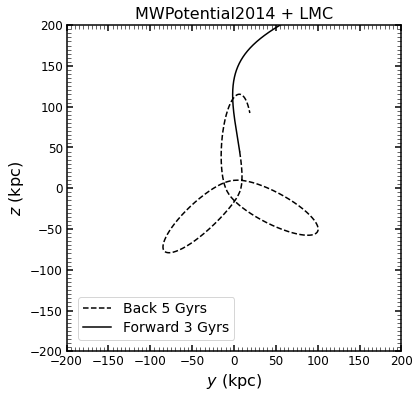

In [9]:
orbit1_backward.plot(d1='y', d2='z', c='k', ls='--', label='Back 5 Gyrs')
orbit1_forward.plot(d1='y', d2='z', c='k', overplot=True, label='Forward 3 Gyrs')

ax = plt.gca()

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('MWPotential2014 + LMC')
ax.legend()

fig = plt.gcf()
fig.set_size_inches(6, 6)

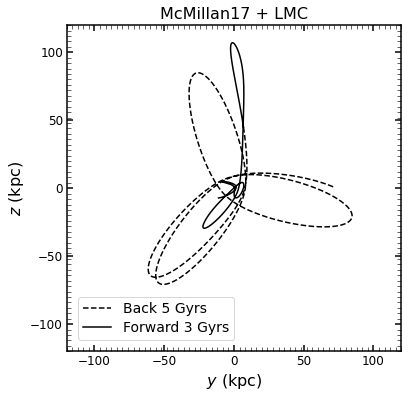

In [10]:
orbit2_backward.plot(d1='y', d2='z', c='k', ls='--', label='Back 5 Gyrs')
orbit2_forward.plot(d1='y', d2='z', c='k', overplot=True, label='Forward 3 Gyrs')

ax = plt.gca()

ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
ax.set_title('McMillan17 + LMC')
ax.legend()

fig = plt.gcf()
fig.set_size_inches(6, 6)

Here are is the forward orbit plotted alone.

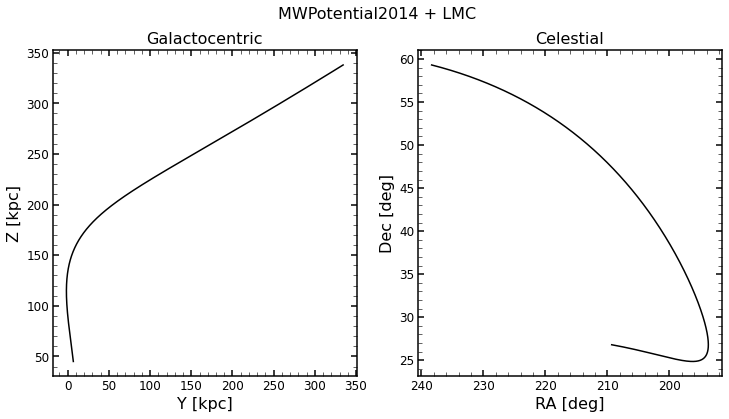

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(orbit1_forward.y(time_forward), orbit1_forward.z(time_forward), c='k')
ax[0].set_title('Galactocentric')
ax[0].set_xlabel('Y [kpc]')
ax[0].set_ylabel('Z [kpc]')

ax[1].plot(orbit1_forward.ra(time_forward), orbit1_forward.dec(time_forward), c='k')
ax[1].invert_xaxis()
ax[1].set_title('Celestial')
ax[1].set_xlabel('RA [deg]')
ax[1].set_ylabel('Dec [deg]')

plt.suptitle('MWPotential2014 + LMC')
plt.show()

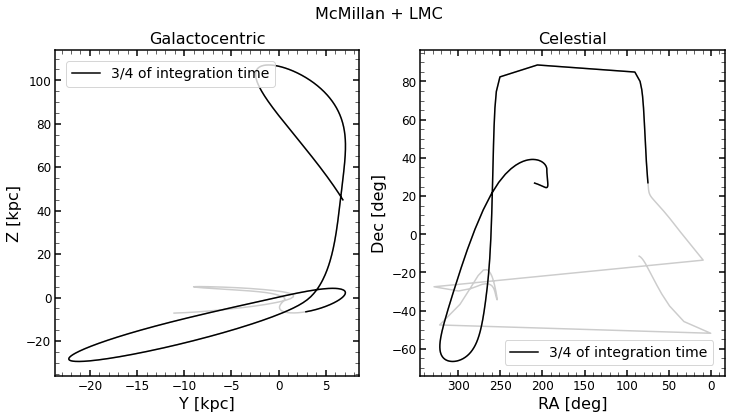

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(orbit2_forward.y(time_forward), orbit2_forward.z(time_forward), c='k', alpha=0.2)
ax[0].plot(orbit2_forward.y(time_forward)[:len(time_forward)*3//4], orbit2_forward.z(time_forward)[:len(time_forward)*3//4], c='k', label='3/4 of integration time')
ax[0].set_title('Galactocentric')
ax[0].set_xlabel('Y [kpc]')
ax[0].set_ylabel('Z [kpc]')
ax[0].legend(loc='upper left')

ax[1].plot(orbit2_forward.ra(time_forward), orbit2_forward.dec(time_forward), c='k', alpha=0.2)
ax[1].plot(orbit2_forward.ra(time_forward)[:len(time_forward)*3//4], orbit2_forward.dec(time_forward)[:len(time_forward)*3//4], c='k', label='3/4 of integration time')
ax[1].invert_xaxis()
ax[1].set_title('Celestial')
ax[1].set_xlabel('RA [deg]')
ax[1].set_ylabel('Dec [deg]')
ax[1].legend()

plt.suptitle('McMillan + LMC')
plt.show()